In [1]:
import numpy as np
from tqdm import tqdm
import cvxpy as cp
import matplotlib.pyplot as plt

from src.mpc import Controller, Dimension
import src.terminal_set as terminal_set
from src.visualise import (
    plot_3d_control,
    plot_action_history,
    plot_state_history,
    plot_terminal_cost_lyupanov,
    plot_disturbance,
)
from main import simulate

Initial state is  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Target state to reach is  [1. 1. 1.]
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-18


Simulating: 100%|██████████| 100/100 [00:03<00:00, 29.05it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


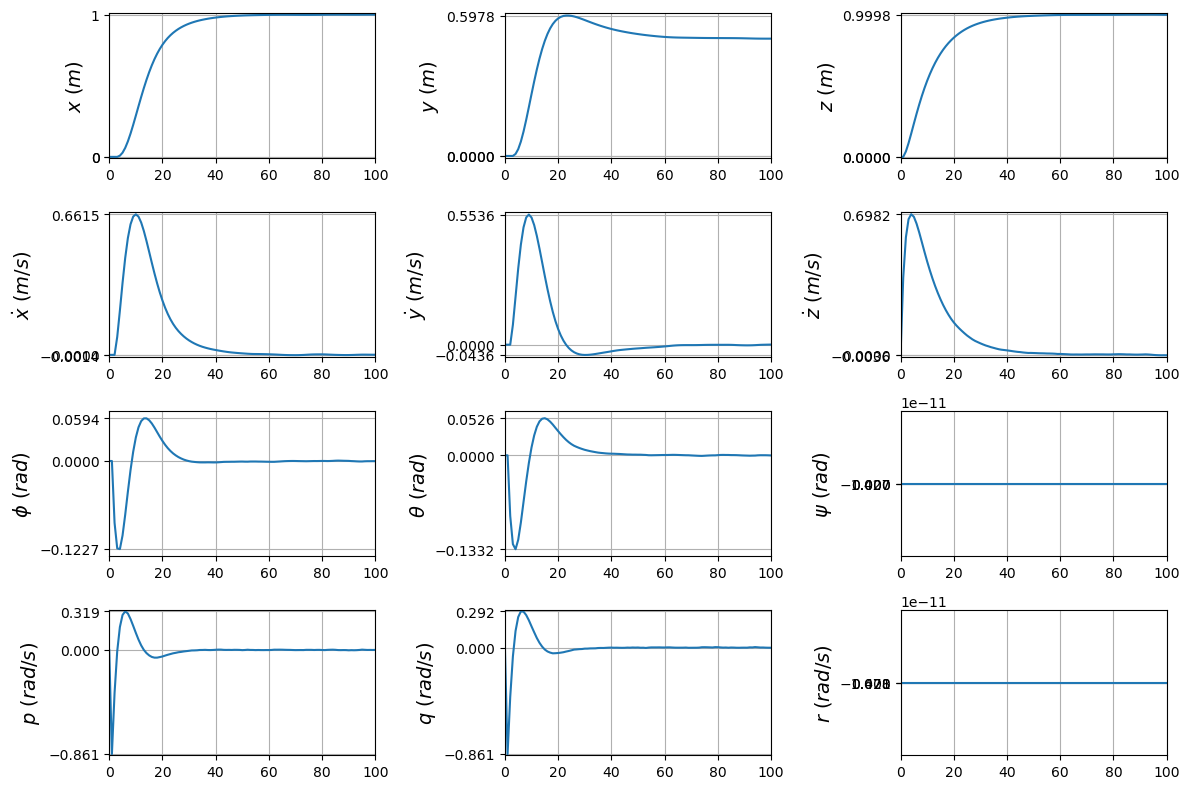

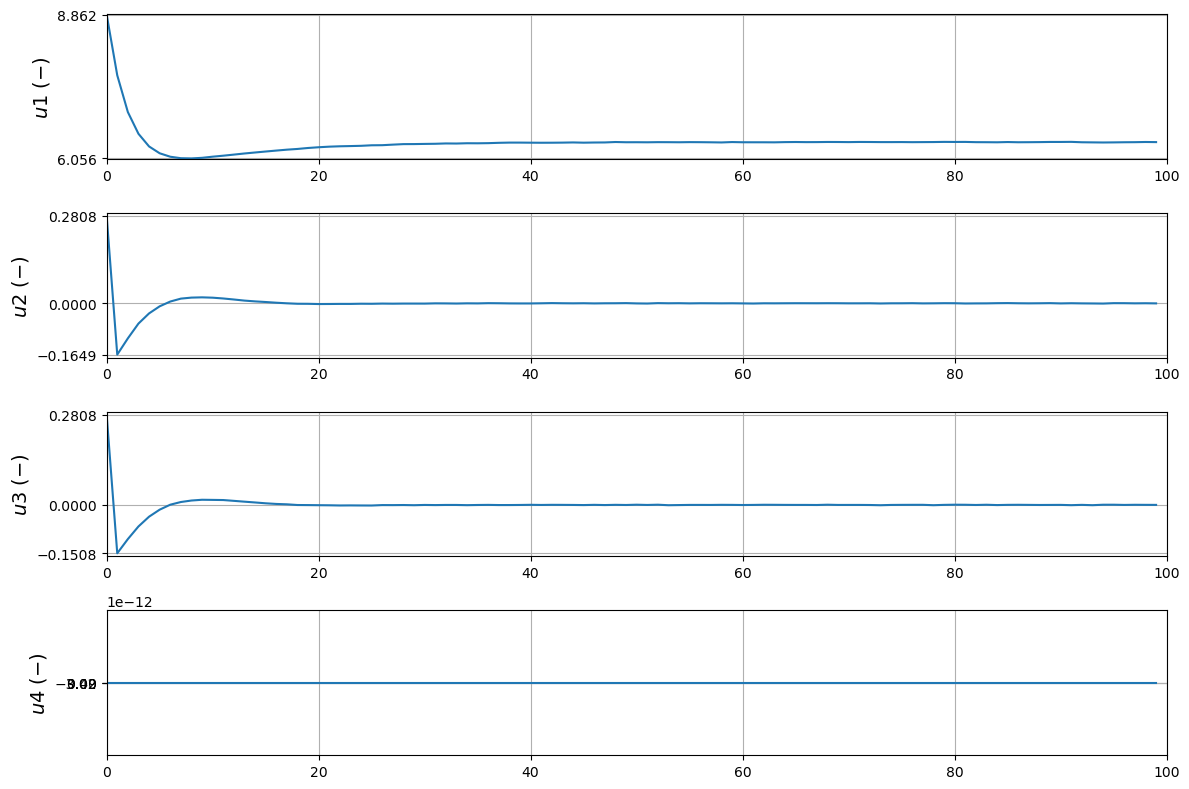

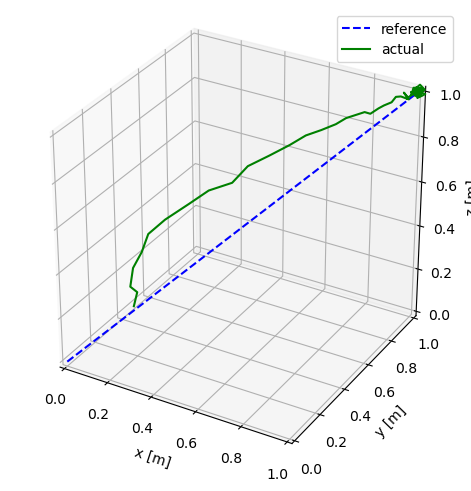

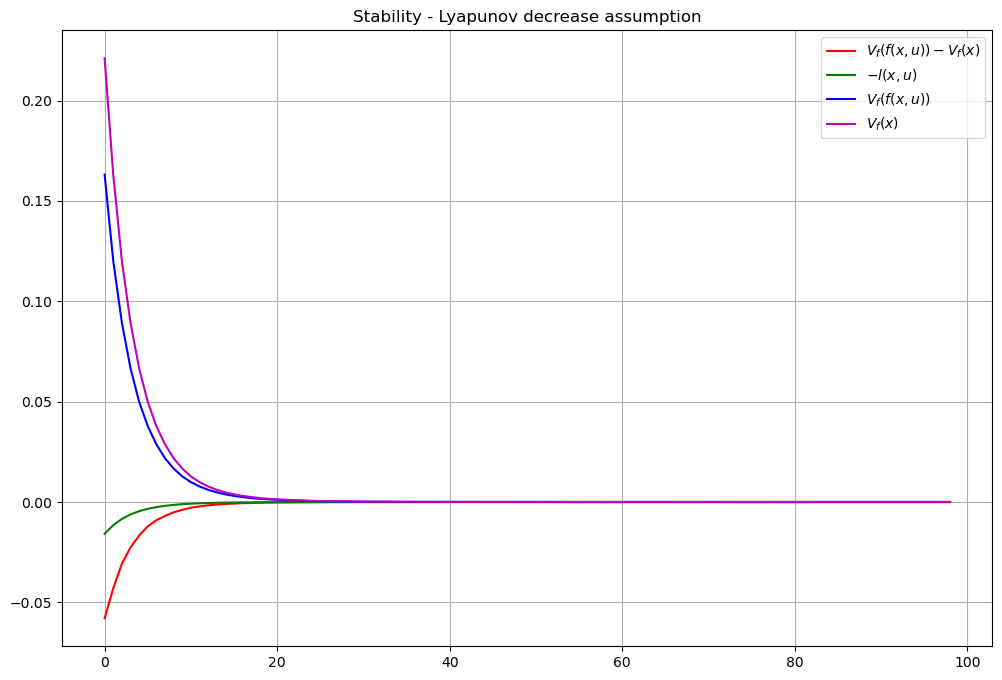

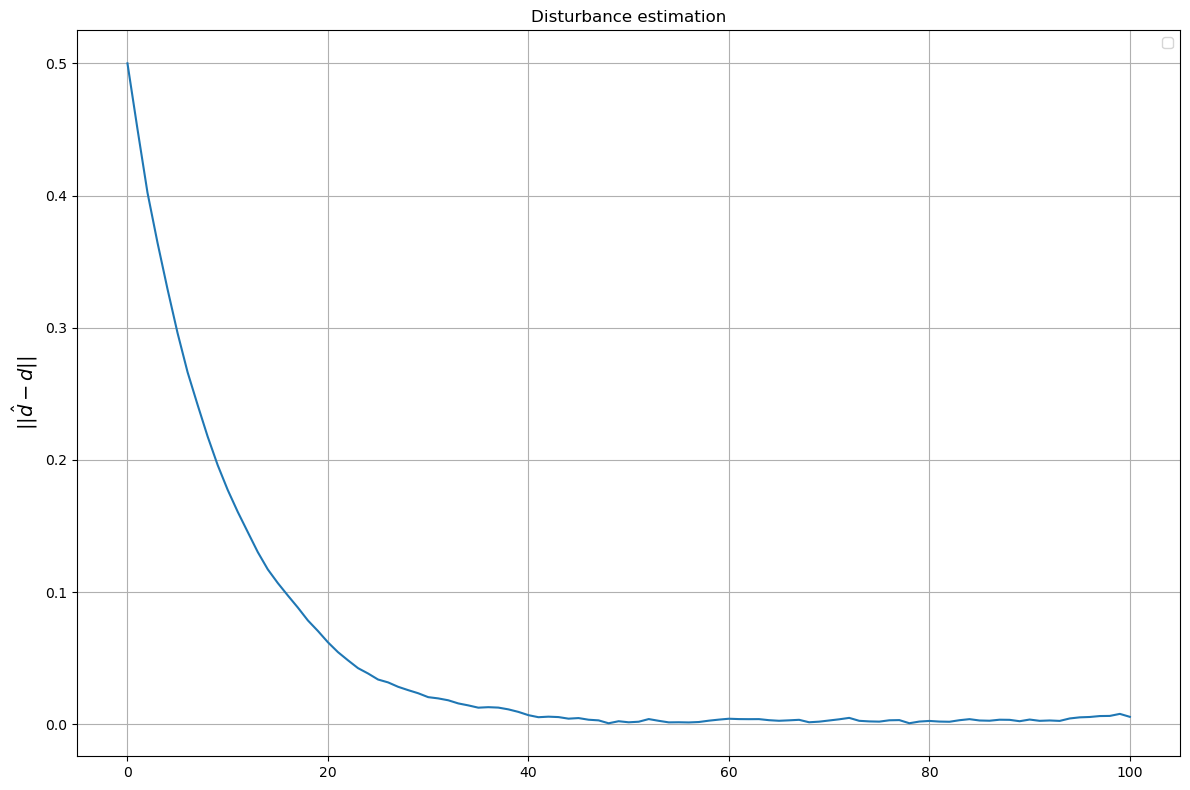

Simulation of mpc with horizon 20, took 3.514543056488037s.


In [2]:
dt = 0.10  # Sampling period
N = 20  # MPC Horizon
T = 100  # Duration of simulation
dim = Dimension(nx=12, nu=4, ny=3, nd=3)

x_init = np.zeros(dim.nx)  # Initial conditions
y_target = np.zeros(dim.ny)  # State to reach
y_target[0:3] = np.array([1.0, 1.0, 1.0])
# y_target[3:6] = np.array([0.1, 0.0, 0.0])

print("Initial state is ", x_init)
print("Target state to reach is ", y_target)

# Controller
ctrl = Controller(
    dim=dim,
    mpc_horizon=N,
    timestep_mpc_stages=dt,
    solver=cp.GUROBI,
    control_type="mpc",  # 'lqr' or 'mpc'
)

# Set disturbance and terminal cost scaling
# ctrl.d = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
ctrl.d = np.array([0.0, 0.5, 0.0])
ctrl.beta = 4.0  # << (very small) beta means you get a behaviour as if tcost was not there at all

states, inputs, plans, Vf, l, outputs, disturbance_est, time_cost = simulate(
    controller=ctrl,
    x_init=x_init,
    y_target=y_target,
    T=T,
    use_terminal_set=False,
    plot=True,
    plots_suffix="_disturbance",
)

print(
        "Simulation of {} with horizon {}, took {}s.".format(
            ctrl.control_type, N, time_cost
        )
    )

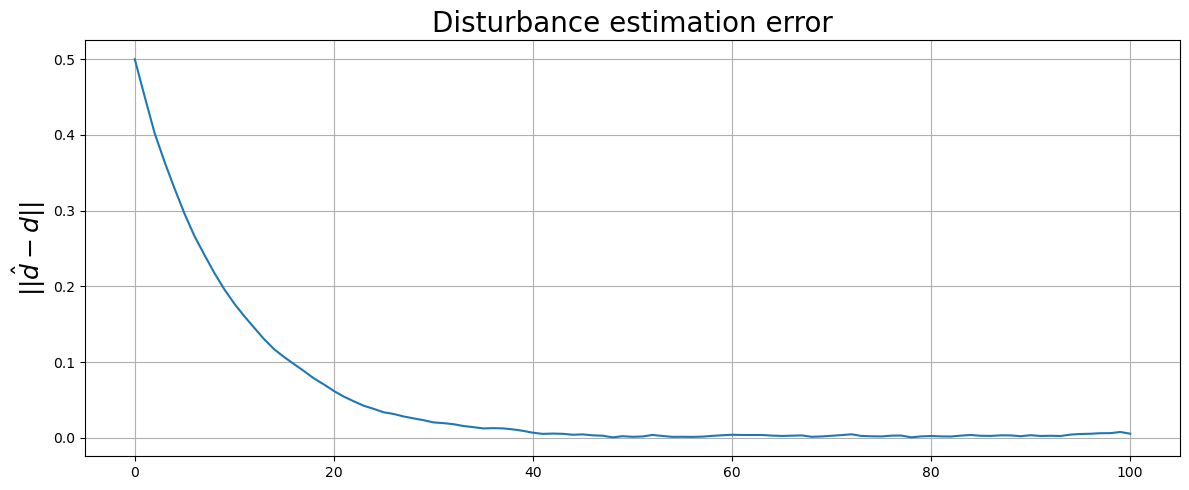

In [6]:
f3 = plt.figure(figsize=(12, 5))
plt.title("Disturbance estimation error", fontsize=20)

d_diff = np.linalg.norm(disturbance_est.T - ctrl.d, axis=1)
plt.ylabel(r"$|| \hat{d} - d ||$", fontsize=18)
plt.plot(d_diff)

plt.grid()
plt.tight_layout()

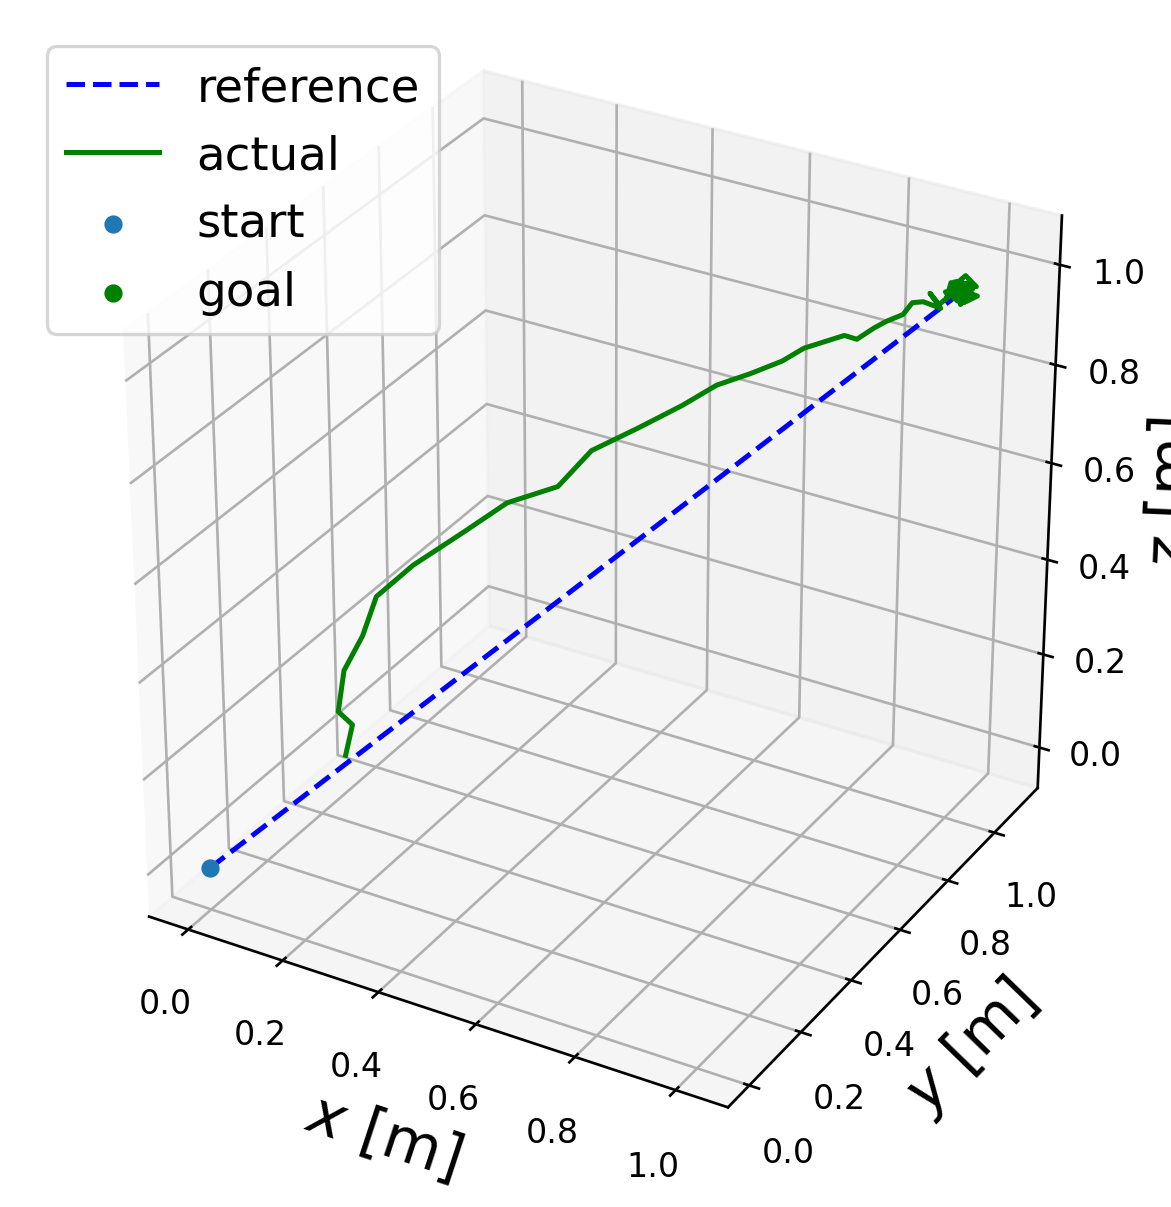

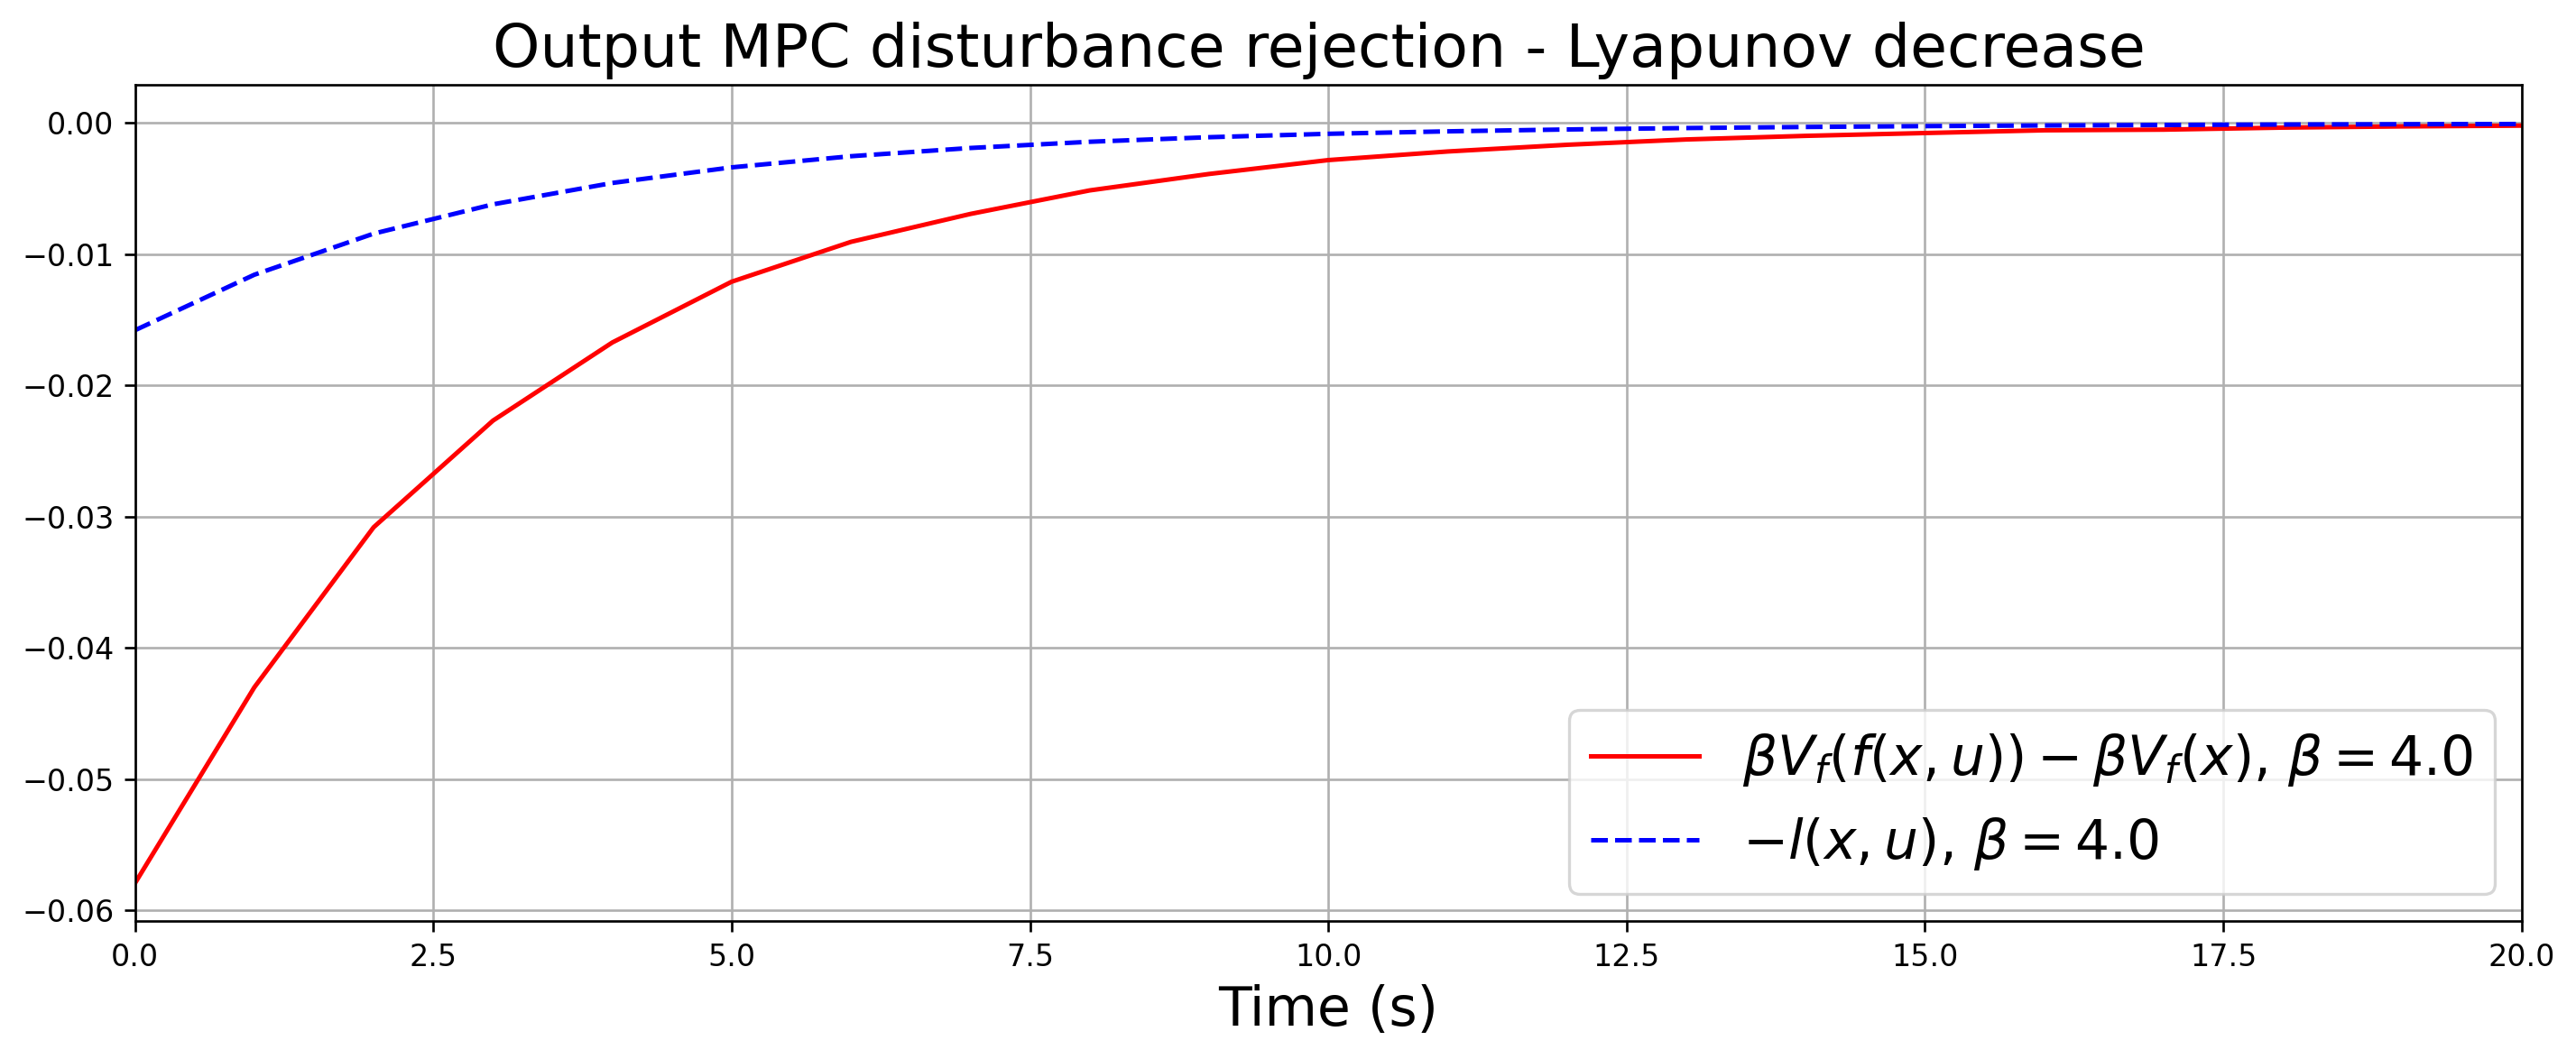

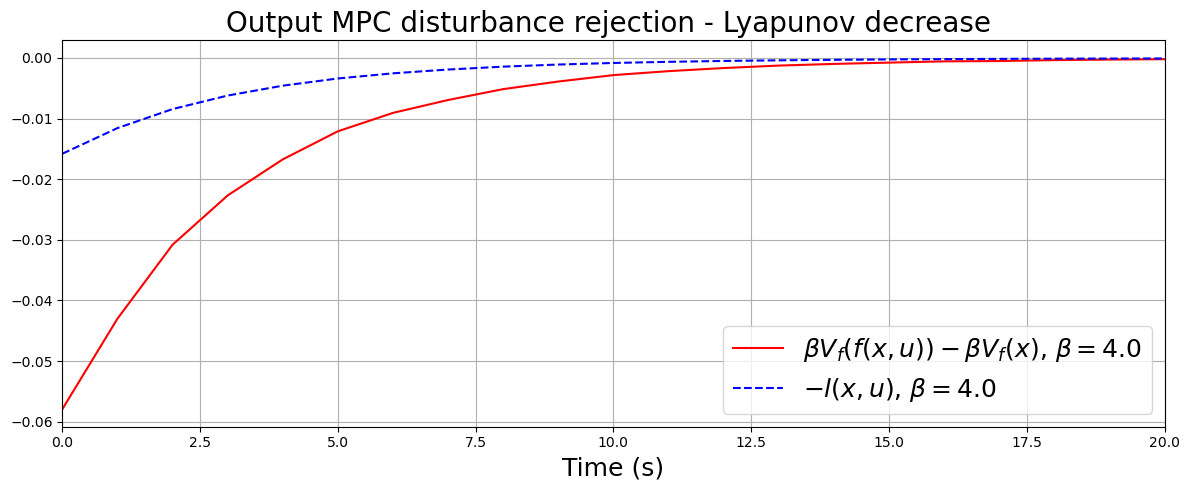

In [28]:
%matplotlib inline
def plot_lyapunov(Vf, l, T,ctrl, plt):
    Vf_diff = Vf[1:] - Vf[0:-1]
    l_diff = l[0:-1]

    plt.plot(range(0, T - 1), Vf_diff,color='r', label=r"$\beta V_f(f(x,u)) - \beta V_f(x)$" + r", $\beta = $" + str(ctrl.beta))
    plt.plot(range(0, T - 1), -l_diff,color='b', linestyle='--', label=r"$-l(x,u)$" + r", $\beta = $" + str(ctrl.beta))
    # plt.plot(range(0, T - 1), Vf[1:], color="b", label=r"$V_f(f(x,u))$")
    # plt.plot(range(0, T - 1), Vf[0:-1], color="m", label=r"$V_f(x)$")

f3 = plt.figure(figsize=(12, 5))
# plot_colortable(mcolors.TABLEAU_COLORS, ncols=2, sort_colors=False)
plt.title(r"Output MPC disturbance rejection - Lyapunov decrease ", fontsize=20)
plot_lyapunov(Vf, l, T, ctrl, plt)
# plot_lyapunov(Vf5, stage_cost5, T, ctrl5, plt, mcolors.TABLEAU_COLORS['tab:brown'])
# plot_lyapunov(Vf6, stage_cost6, T, ctrl6, plt, mcolors.TABLEAU_COLORS['tab:pink'])

plt.xlim((0, 20))
plt.xlabel("Time (s)", fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
plt.grid()
plt.show()

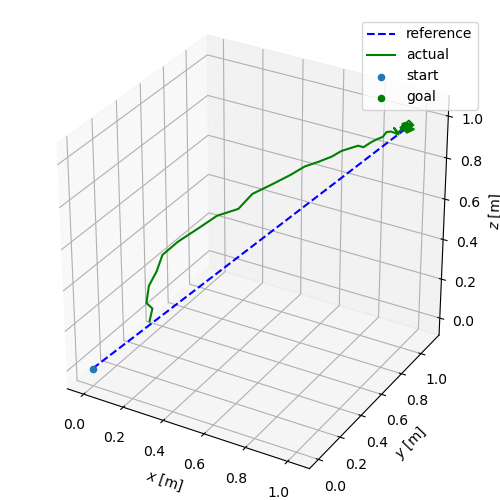

In [29]:
%matplotlib widget
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection="3d")

ax.plot(
    [x_init[0], y_target[0]],
    [x_init[1], y_target[1]],
    [x_init[2], y_target[2]],
    label="reference",
    color="b",
    linestyle="--",
)

ax.plot(
        outputs.T[:, 0],
        outputs.T[:, 1],
        outputs.T[:, 2],
        label="actual",
        color="g",
        linestyle="-",
        zorder=10,
    )

ax.scatter(x_init[0], x_init[1], x_init[2], label=r"start")
ax.scatter(y_target[0], y_target[1], y_target[2], color="g", label=r"goal")
ax.autoscale(False)
ax.set_box_aspect((1, 1, 1.0))
ax.set_xlabel(r"$x$ [m]")
ax.set_ylabel(r"$y$ [m]")
ax.set_zlabel(r"$z$ [m]")
ax.legend()
fig.tight_layout()
plt.savefig("reference_baseline.png")
plt.show()


In [16]:
x_target = np.zeros(12)
x_target[:3] = y_target
c, vertices = terminal_set.calculate_c(ctrl, x_target, debug=True)

Text(0.5, 1.0, 'Polyhedral outer approximation of $X_f$')

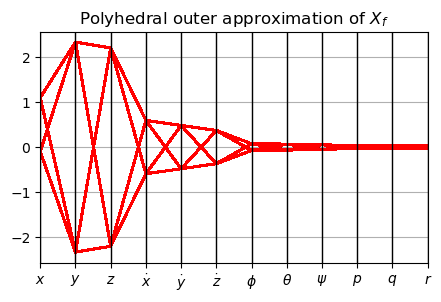

In [23]:
import pandas as pd
from pandas import read_csv
from pandas.plotting import parallel_coordinates
from matplotlib import pyplot as plt

# plt = plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(figsize=(5,3))

df = pd.DataFrame(vertices, columns = [r"$x$",r"$y$",r"$z$", r"$\dot{x}$", r"$\dot{y}$", r"$\dot{z}$", r"$\phi$", r"$\theta$",r"$\psi$",r"$p$",r"$q$",r"$r$"])
df["Name"] = np.random.randn()

parallel_coordinates(df, "Name", ax=ax, color='red')
ax.legend().set_visible(False)
ax.set_title(r"Polyhedral outer approximation of $X_f$")
# plt.legend()
# plt.show()

#vertices = 4096 x 12